<a href="https://colab.research.google.com/github/evandrofr/visao_projeto2/blob/main/projeto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PROJETO 2

**Alunos:**

Cicero Tiago

Evandro Romeiro

### Objetivo do projeto

O objetivo principal do projeto é a conversão de uma figura tridimensional desenhada em uma superfície plana em um modelo 3D virtual. 

Com isso, para fins de prototipação, foram realizados tratamentos em alguns desenhos de cubos para explorar as possibilidades e encontrar limitações.

In [1]:
# Importação de algumas bibliotecas 
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [2]:
# redimensiona imagem sem perder o aspect ratio
def resize_safe(image, width=None, height=None, inter=cv.INTER_AREA):
    # https://stackoverflow.com/a/58126805
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv.resize(image, dim, interpolation=inter)

Cubo 1


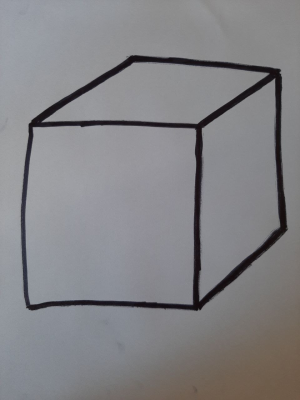

Cubo 2


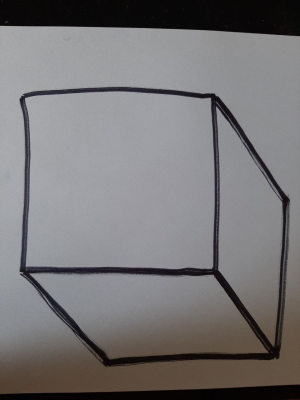

In [3]:
img1 = cv.imread('cubo_06.jpg')
print("Cubo 1")
cv2_imshow(resize_safe(img1, 300))
img2 = cv.imread('cubo_05.jpg')
print("Cubo 2")
cv2_imshow(resize_safe(img2, 300))

Todas as ocorrências:


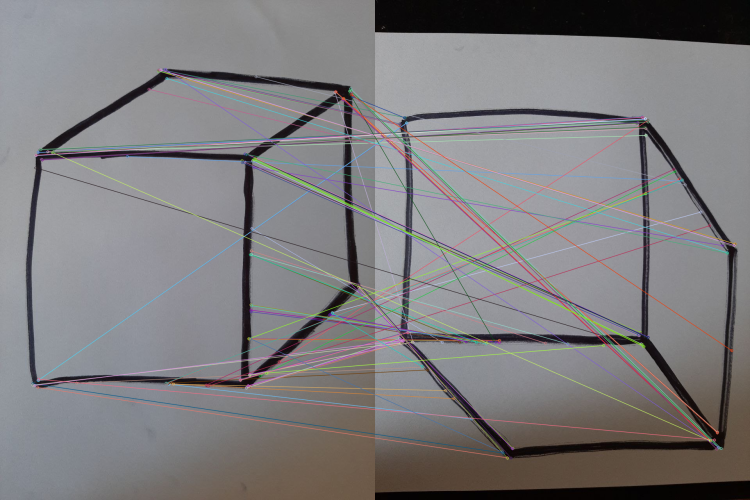

In [4]:
orb = cv.ORB_create()
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches,None, flags=2)
print("Todas as ocorrências:")
cv2_imshow(resize_safe(img3, height=500))

Somente as doze primeiras correspondências:
(643.0, 651.0) <--> (123.0, 940.0)
(423.0, 177.0) <--> (233.0, 874.0)
(918.0, 727.0) <--> (891.0, 627.0)
(920.0, 729.0) <--> (919.0, 628.0)
(405.0, 181.0) <--> (75.0, 307.0)
(630.0, 993.0) <--> (874.0, 1149.0)
(921.0, 731.0) <--> (810.0, 504.0)
(919.0, 732.0) <--> (879.0, 1145.0)
(411.0, 179.0) <--> (692.0, 342.0)
(640.0, 991.0) <--> (858.0, 1128.0)
(851.0, 801.0) <--> (922.0, 624.0)
(448.0, 982.0) <--> (923.0, 632.0)


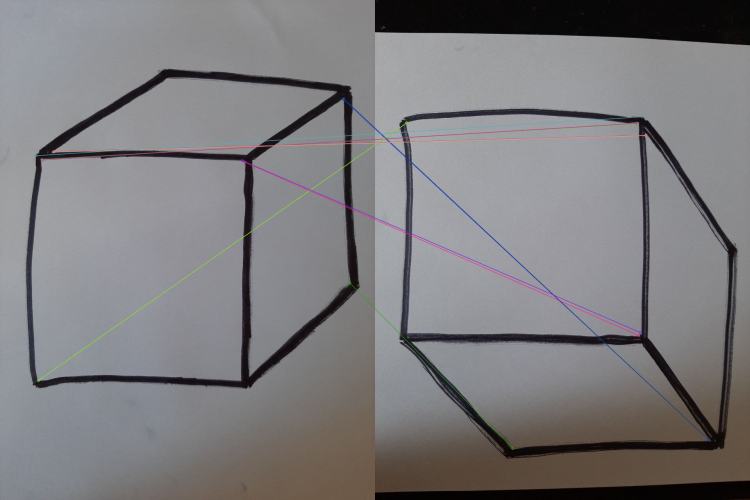

In [5]:
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:12],None, flags=2)
print("Somente as doze primeiras correspondências:")
for i in range(12):
  print(kp1[i].pt,"<-->",kp2[i].pt)
cv2_imshow(resize_safe(img3, height=500))

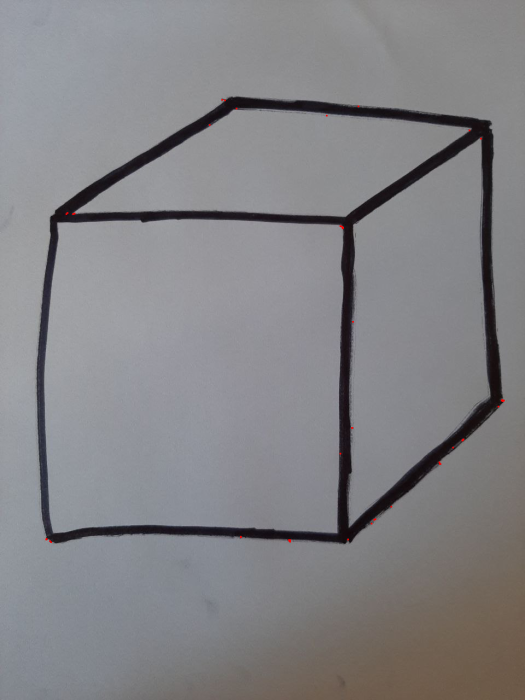

In [6]:
img = cv.imread('cubo_06.jpg')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv.cornerHarris(gray,2,3,0.2) #Documentação: https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345
dst = cv.dilate(dst,None)
img_copy = img.copy()
img_copy[dst>0.01*dst.max()]=[0,0,255]
cv2_imshow(resize_safe(img_copy, height=700))

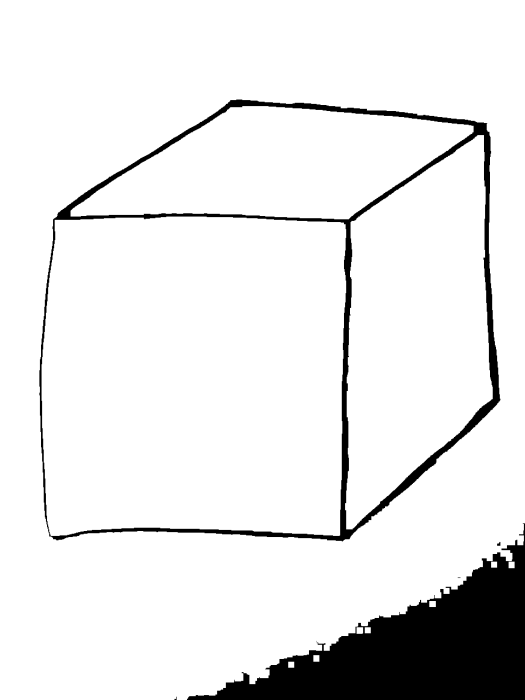

In [7]:
image = cv.imread('cubo_06.jpg')
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
# cv2_imshow(gray)
thresh = np.median(gray) - 30
im_bw = cv.threshold(gray, thresh, 255, cv.THRESH_BINARY)[1]
im_bw = cv.bitwise_not(im_bw)
# cv2_imshow(im_bw)

kernel = np.ones((3,3),np.uint8)
erosion = cv.erode(im_bw,kernel,iterations = 5)
erosion = cv.bitwise_not(erosion)
cv2_imshow(resize_safe(erosion, height=700))

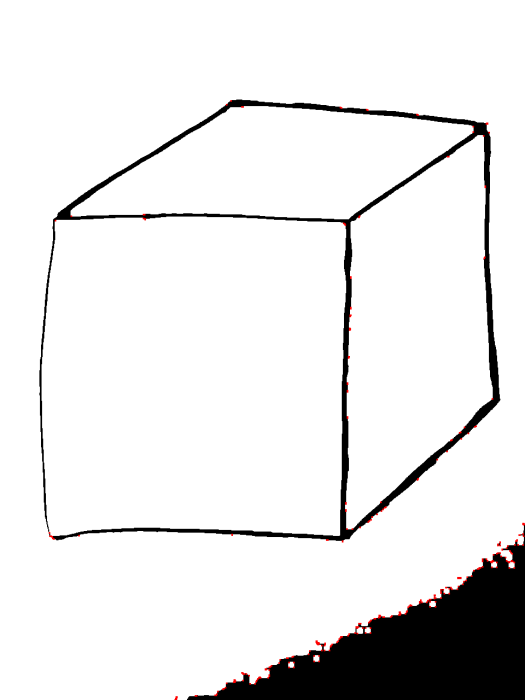

In [8]:
image_eroded = cv.cvtColor(erosion, cv.COLOR_GRAY2BGR)
erosion = np.float32(erosion)
dst = cv.cornerHarris(erosion,2,3,0.1) #Documentação: https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345
dst = cv.dilate(dst,None)
# cv2_imshow(dst)
# print("")
image_copy = image_eroded.copy()
image_copy[dst>0.01*dst.max()]=[0,0,255]
cv2_imshow(resize_safe(image_copy, height=700))

In [9]:
!pip install imutils

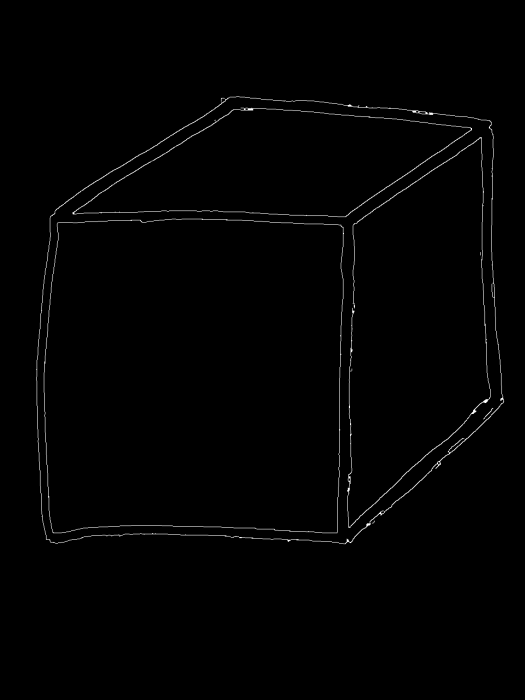

In [10]:
import imutils
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours

image = cv.imread('cubo_06.jpg')
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
gray = cv.GaussianBlur(gray, (7, 7), 0)

#calculamos as arestas e realizamos uma dilatação + erosão para fechar
#eventuais gaps entre as arestas dos objetos
edged = cv.Canny(gray, 50, 100)
edged = cv.dilate(edged, None, iterations=1)
edged = cv.erode(edged, None, iterations=1)
cv2_imshow(resize_safe(edged, height=700))

cnts = cv.findContours(edged.copy(),cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
(cnts, _) = contours.sort_contours(cnts)

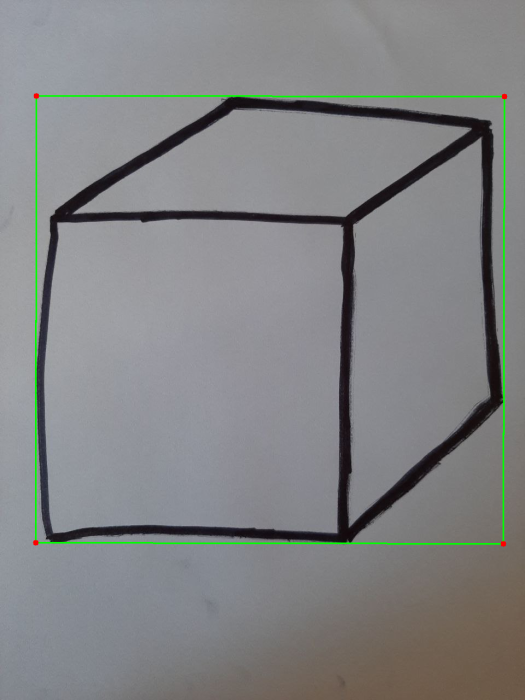

In [11]:
orig = image.copy()

#Percorre todos os contornos
for c in cnts:
  # se o contorno não é suficientemente grande, ignorá-lo
  if cv.contourArea(c) < 10:
    continue
  # calcula a bounding box rotacionada do contorno
  box = cv.minAreaRect(c)
  box = cv.boxPoints(box) 
  box = np.array(box, dtype="int")
  #ordena os pontos do contorno de tal modo que eles
  #apareçam na seguinte ordem: topo-esquerda, topo-direita,
  #base-direita e base-esquerda
  box = perspective.order_points(box)
  cv.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
  for (x, y) in box:
    cv.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)

cv2_imshow(resize_safe(orig, height=700))

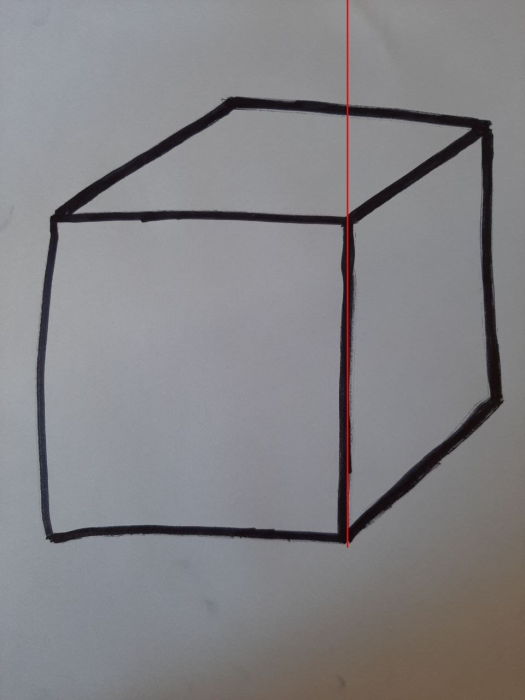

In [12]:
orig = image.copy()
lines = cv.HoughLines(edged, 10, np.pi / 180, 150, None, 0, 0)
for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv.line(orig,(x1,y1),(x2,y2),(0,0,255),2)

cv2_imshow(resize_safe(orig, height=700))

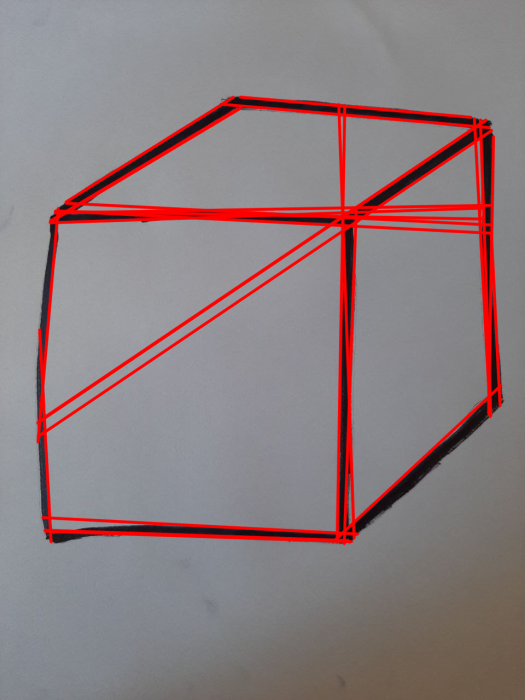

In [13]:
orig2 = image.copy()
linesP = cv.HoughLinesP(edged, 1, np.pi/180, 100, None, 300, 1000)
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv.line(orig2, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)

cv2_imshow(resize_safe(orig2, height=700))

### Configuração de parâmetros

A celula abaixo recebe alguns parâmetros do usuário para utilizar na função de reconhecimento de linhas

In [14]:
dists = []

rho = 1.0

theta = np.pi / 180

threshold = int(input("Digite o valor do parâmetro 'threshold' (sugestão:  100): "))

lines=None

minLineLength = int(input("Digite o valor do parâmetro 'minLineLength' (sugestão:  300): "))

maxLineGap = int(input("Digite o valor do parâmetro 'maxLineGap' (sugestão:  100): "))

Digite o valor do parâmetro 'threshold' (sugestão:  100): 100
Digite o valor do parâmetro 'minLineLength' (sugestão:  300): 300
Digite o valor do parâmetro 'maxLineGap' (sugestão:  100): 100


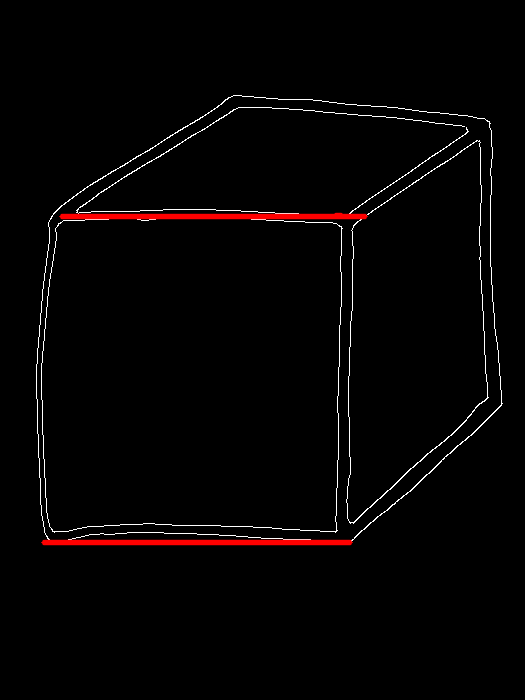

Avg Edge: 312.55693782644806


In [15]:
def dist(p1, p2):
    # calcula distância entre pontos
    x1, y1 = p1
    x2, y2 = p2
    return ( (x2 - x1)**2 + (y2 - y1)**2 ) ** 0.5

def calc_mean(list):
    # calcula média dos valores numéricos de uma lista
    l = len(list)
    if l:
        return sum(list)/len(list)
    return l

def apply_blur(img, k_size=5):
    # aplica o efeito de blur em uma imagem
    kernel = np.ones((k_size, k_size), np.float32)/k_size**2
    return cv.filter2D(img, -1, kernel)

def to_gray(img):
    # converte imagem de 3 para 1 canal em escala de cinza
    return cv.cvtColor(img, cv.COLOR_BGR2GRAY)

def to_bgr(mono):
    # converte imagem de 1 para 3 canais
    return cv.cvtColor(mono, cv.COLOR_GRAY2BGR)

def process_image(img):
    # aplica um conjunto de operações para processar imagem
    gray = to_gray(img)

    gray = apply_blur(gray, k_size=7)

    # threshold
    thresh = gray.mean() - 50
    im_bw = cv.threshold(gray, thresh, 255, cv.THRESH_BINARY)[1]

    # inversão
    im_bw = cv.bitwise_not(im_bw)

    kernel = np.ones((3,3), np.uint8)
    blur = apply_blur(im_bw, k_size=5)
    edged = cv.Canny(blur, 50, 100)

    return edged

def get_lines(binary_img):
    # detecta linhas em uma imagem
    linesP = cv.HoughLinesP(image=binary_img, 
                            rho=rho, theta=theta, 
                            threshold=threshold, 
                            lines=lines, 
                            minLineLength=minLineLength,
                            maxLineGap=maxLineGap)
    return linesP
  
def draw_lines(binary_img, lines):
    # desenha linhas em uma imagem
    print('\n')

    output = to_bgr(binary_img)

    if lines is not None:
        for i in range(0, len(lines)):
            l = lines[i][0]
            x1,y1 = l[:2]
            x2,y2 = l[2:4] 
            
            cv.line(output, (x1,y2), (x2,y2), (0, 0, 255), 3, cv.LINE_AA)
    
    cv2_imshow(output)

def get_avg(lines):
    # calcula média dos comprimentos das linas detectadas
    dists = []
    if lines is not None:
        for i in range(0, len(lines)):
            l = lines[i][0]
            x1,y1 = l[:2]
            x2,y2 = l[2:4]

            delta = dist((x1,y1), (x2,y2))
            dists.append(delta)
            
    return calc_mean(dists)

filename = 'cubo_06.jpg'
img = cv.imread(filename)
img = resize_safe(img, height=700)
processed = process_image(img)
lines = get_lines(processed)
draw_lines(processed, lines)

mean_edge = get_avg(lines)

print("Avg Edge:", mean_edge)


In [16]:
# instala a biblioteca de RayTracer
!pip install pyRT

     |████████████████████████████████| 40 kB 3.5 MB/s 


In [17]:
from pyrt.math import Vec3
from pyrt.scene import Scene
from pyrt.light import PointLight
from pyrt.geometry import Triangle, Sphere, Vertex
from pyrt.material import PhongMaterial
from pyrt.camera import PerspectiveCamera
from pyrt.renderer import SimpleRT
from PIL import Image

# cubo com aresta de 300px tem tamanho 2u no RayTracer
BASE_CUBE_EDGE = 2

# calcula a aresta do cubo em escala
l = mean_edge*2/300

# tamanho da aresta da base
floor_size = l + 0.5


# altura e largura da image
width = 640
height = 480

# configurações de posicionamento da câmera:
camera = PerspectiveCamera(width, height, 30)
camera.setView(Vec3(4*l, -6.5*l, 6.5*l), Vec3(0., 0., 0.), Vec3(0.,0.,1.))

# cria uma cena
scene = Scene()

# adiciona luz à cena
scene.addLight(PointLight(Vec3(10,-10, 5)))


# configura algumas opções de materiais
floormaterial = PhongMaterial(color=Vec3(0.5,0.5,0.5))
material1 = PhongMaterial(color=Vec3(1.,0.,0.), reflectivity=0.4)
material2 = PhongMaterial(color=Vec3(1.,1.,0.), reflectivity=0.4)
material3 = PhongMaterial(color=Vec3(1.,0.,1.), reflectivity=0.4)
material4 = PhongMaterial(color=Vec3(0.,1.,0.), reflectivity=0.4)
material5 = PhongMaterial(color=Vec3(0.,1.,1.), reflectivity=0.4)
material6 = PhongMaterial(color=Vec3(0.,0.,1.), reflectivity=0.4)


# adiciona a base
A = Vertex(position=(-floor_size, -floor_size, 0.0))
B = Vertex(position=( floor_size, -floor_size, 0.0))
C = Vertex(position=( floor_size,  floor_size, 0.0))
D = Vertex(position=(-floor_size,  floor_size, 0.0))

# Vertices de baixo
V1 = Vertex(position=( l,-l, 0))
V2 = Vertex(position=( l, l, 0))
V3 = Vertex(position=(-l, l, 0))
V4 = Vertex(position=(-l,-l, 0))

# Vertices de cima
V5 = Vertex(position=( l,-l, 2*l))
V6 = Vertex(position=( l, l, 2*l))
V7 = Vertex(position=(-l, l, 2*l))
V8 = Vertex(position=(-l,-l, 2*l))

# Face frente
scene.add(Triangle(V2,V5,V1, material=material1))
scene.add(Triangle(V2,V5,V6, material=material2))

# Face esquerda
scene.add(Triangle(V2,V6,V7, material=material2))
scene.add(Triangle(V2,V3,V7, material=material2))

# Face trás
scene.add(Triangle(V3,V7,V8, material=material3))
scene.add(Triangle(V3,V4,V8, material=material3))

# Face direita
scene.add(Triangle(V4,V5,V8, material=material4))
scene.add(Triangle(V1,V4,V5, material=material4))

# Face baixo
scene.add(Triangle(V1,V2,V4, material=material5))
scene.add(Triangle(V2,V3,V4, material=material5))

# Face cima
scene.add(Triangle(V5,V6,V8, material=material6))
scene.add(Triangle(V6,V7,V8, material=material6))

scene.add(Triangle(A,B,C, material=floormaterial))
scene.add(Triangle(A,C,D, material=floormaterial))

# seleciona a camera a ser usada
scene.setCamera(camera)

# cria o ray tracer "SimpleRT"
engine = SimpleRT(shadow=True,iterations=2)

# renderiza a cena:
image = engine.render(scene)

# salva a image usando pillow
image.save("render.png")


# Creating Renderer: Simple Raytracer
# Shadow Enabled
# Iterations: 2
# RENDER STATISTICS###############################
TIME FOR RENDERING: 84.00290942192078s
NUMBER OF PRIMARY RAYS: 307200
NUMBER OF SECONDARY RAYS: 62597
NUMBER OF SHADOW RAYS: 126090
RAYS/s: 5903.212203154919
##################################################


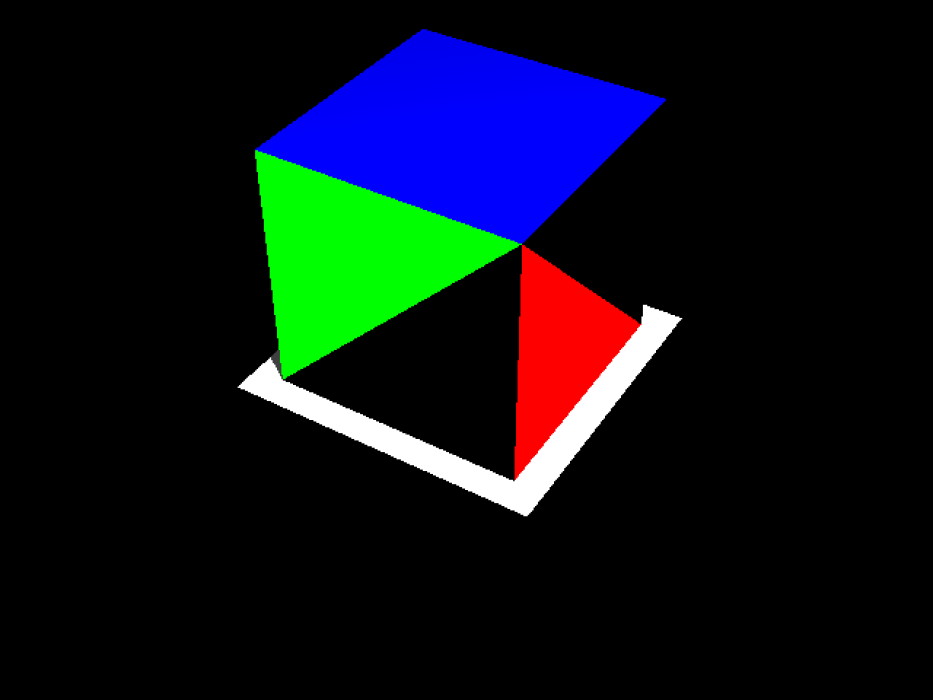

In [18]:
img3D = cv.imread('render.png')
img3D = resize_safe(img3D, height=700)
cv2_imshow(img3D)